<a href="https://colab.research.google.com/github/Kicory/ML_StockPJ/blob/master/Notebook/Season2/TheGrandPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기초 설정 등

In [2]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# for teaching force
import random

# for CSV
import pandas as pd
import numpy as np

# for visual plot
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# for data
import sklearn.preprocessing as skpp
import sklearn.model_selection as skms

from tqdm import tnrange as trange

# 0. 시작하기

In [0]:
################################################################################
##### CONFIG ###################################################################
################################################################################
device = 'cuda'

torch.manual_seed(470)
torch.cuda.manual_seed(470)

DATA_DIR = os.path.join(gdrive_root, 'Project/Data')
DATA_PATH = os.path.join(DATA_DIR, 'KOSPI.csv')
CHECKPOINT_PATH = os.path.join(gdrive_root, 'Project/checkpoints/KOSPI_4.pt')

UsingCols = [1, 2, 3, 4, 5, 6, 7, 8]
HiddenSize_1 = 4
DropoutRate = 0
HiddenSize_2 = 8
BatchSize = 32

NormalizeRange = (-1, 1)

GivenCnt = 5
PredictCnt = 2
################################################################################
UsingColsCnt = len(UsingCols)

# 1. 데이터 준비하기

### **Input Unit**
Input Unit은 `GivenCnt + PredictCnt`개의 연속된 데이터(하루가 데이터 1개).

모델에 Input Unit의 최초 `GivenCnt`개 데이터를 lstm에 차례로 입력하면, 그 데이터를 바탕으로 `PredictCnt`개의 데이터를 계산해 내는 구조.

추측해 낸 데이터를 Input Unit의 나머지 `PredictCnt`개의 데이터와 mse를 취한 것이 loss가 된다.

## 불러오기 및 기본적 가공
csv를 불러오는 데는 pandas를, 데이터를 가공하는 데는 sklearn을 사용한다.

sklearn을 이용하면 데이터의 범위를 모두 비슷하게 맞춰줄 수 있는데, 이렇게 하면 모델이 훨씬 학습을 쉽게 한다.

KOSPI 주가 데이터의 경우

1.   가격은 원화로 1000원에서 3000원 사이
2.   가격 등락을 나타내는 지표는 -100 에서 100 사이 정도
3.   거래량의 경우 몇만 단위를 넘어감

그렇기 때문에 scaler을 이용해서 모두 같은 범위의 크기로 만들어 주어야, 모델이 헷갈리지 않고 학습할 수 있다. 그렇지 않으면 어떤 데이터에서만 지나치게 loss가 많이 계산되어 다른 데이터를 무시하게 되고, 학습이 효율적으로 이루어지지 않는다.

---

아래 코드는 CONFIG에서 설정한 `NormalizeRange`의 범위로 모든 데이터의 범위를 맞춰 줌.

(모델 내에 ReLU가 있기 때문에 0을 중심으로 normalize하는 것이 도움이 될 지도 모른다.)




In [0]:
DATA = pd.read_csv(DATA_PATH, engine='c', usecols=UsingCols)

In [88]:
TRAIN_DF, TEST_DF = skms.train_test_split(DATA, train_size=0.8, test_size=0.2, shuffle=False)
print('Train :', len(TRAIN_DF), '\nTest :', len(TEST_DF))
scaler = skpp.MinMaxScaler(feature_range=NormalizeRange)
TRAIN = scaler.fit_transform(TRAIN_DF.to_numpy())
TEST = scaler.transform(TEST_DF.to_numpy())

Train : 5098 
Test : 1275


In [0]:
def unscale(x):
  return scaler.inverse_transform(x)

## 데이터 확인
scale되지 않은 데이터를 그래프로 보여줌. 

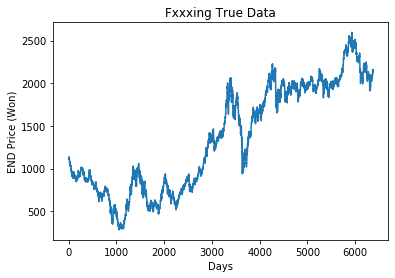

In [0]:
plt.figure()
plt.plot(DATA["END"])
plt.title('Fxxxing True Data')
plt.ylabel('END Price (Won)')
plt.xlabel('Days')
plt.show()

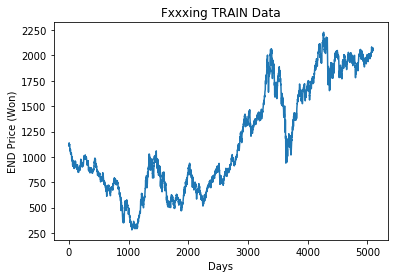

In [0]:
plt.figure()
plt.plot(TRAIN_DF["END"])
plt.title('Fxxxing TRAIN Data')
plt.ylabel('END Price (Won)')
plt.xlabel('Days')
plt.show()

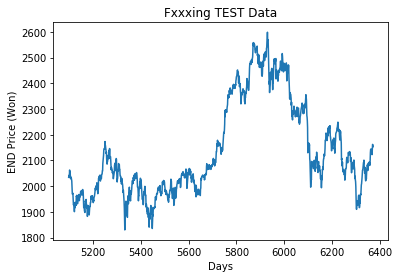

In [0]:
plt.figure()
plt.plot(TEST_DF["END"])
plt.title('Fxxxing TEST Data')
plt.ylabel('END Price (Won)')
plt.xlabel('Days')
plt.show()

## 데이터 가공해서 뿌려주는 함수들

### `makeInputUnits(whole, given, predicting)`
makeInputUnits는 연속된 전체 데이터(`whole`)를 이용해서 Input Unit의 배열을 만들어내는 함수이다. 

리턴하는 두 개의 numpy 리스트는 각각 `given`개와 `predicting`개 데이터 리스트의 리스트이다.

In [0]:
def makeInputUnits(whole, given, predicting):
  entryCnt = whole.shape[0]
  entryDim = whole.shape[1]

  unitLen = given + predicting
  unitCnt = entryCnt - unitLen + 1

  givenEntries = np.zeros((unitCnt, given, entryDim))
  predictEntries = np.zeros((unitCnt, predicting, entryDim))

  for idx in range(unitCnt):
    givenEntries[idx] = whole[idx : idx + given]
    predictEntries[idx] = whole[idx + given : idx + given + predicting]
  
  return givenEntries, predictEntries

### `makeBatches(givens, predicts, b_size, shuffle=False)`

`makeInputUnits`에서 만든 input unit들을 서로 묶어서 batch로 만들어주는 함수

`shuffle`이 `True`면 각 batch들의 순서가 무작위가 된다. 시간순으로 학습하지 않아 조금은 overfitting에 도움이 될 지도.

In [0]:
def makeBatches(givens, predicts, b_size, shuffle=False):
  unitCnt = givens.shape[0]
  unitsLeft = unitCnt

  givenLen = givens.shape[1]
  predictLen = predicts.shape[1]

  entryDim = givens.shape[2]

  unitPointer = 0

  toReturn = []

  while unitsLeft >= b_size:
    retBatchGivens = givens[unitPointer : unitPointer + b_size]
    retBatchPredicts = predicts[unitPointer : unitPointer + b_size]

    unitsLeft = unitsLeft - b_size
    unitPointer = unitPointer + b_size
    
    toReturn.append((torch.Tensor(retBatchGivens.swapaxes(0, 1)), torch.Tensor(retBatchPredicts.swapaxes(0, 1))))
  
  if shuffle:
    random.shuffle(toReturn)

  for tup in toReturn:
    yield tup


## 테스트

In [0]:
G, P = makeInputUnits(TRAIN, GivenCnt, PredictCnt)
batIter = makeBatches(G, P, BatchSize)
for bat in batIter:
  GG, PP = bat
  print(GG.shape)
  print(PP.shape)
  break

torch.Size([7, 32, 8])
torch.Size([13, 32, 8])


# 2. 모델 만들기

## 모델 코드

LSTM의 output에 대해,

*   dropout
*   Fully Connected layer
*   Activation layer (ReLU)
*   Fully connected

을 거친 값이 model의 output이 되고, 해당 결과는 다시 LSTM의 다음 input으로 들어간다.



In [0]:
class GrandPredictor(nn.Module):
  def __init__(self, hiddenSize=16, dropoutRate=0.2, FcHiddenSize=16):
    super(GrandPredictor, self).__init__()
    self.lstm = nn.LSTMCell(UsingColsCnt, hiddenSize)
    self.dropout = nn.Dropout(p=dropoutRate)
    self.Fc_mid = nn.Linear(hiddenSize, FcHiddenSize)
    self.relu = nn.ReLU()
    self.Fc_out = nn.Linear(FcHiddenSize, UsingColsCnt)

  def forwardAfterLSTM(self, x):
    x = self.dropout(x)
    x = self.relu(self.Fc_mid(x))
    return self.Fc_out(x)

  def forward(self, givens, predictCnt):
    givens = givens.to(device)
    
    h, c = None, None

    for G in givens:
      if h is None or c is None:
        h, c = self.lstm(G)
      else:
        h, c = self.lstm(G, (h, c))

    predicted = torch.zeros((predictCnt, BatchSize, UsingColsCnt))
    P = self.forwardAfterLSTM(h)
    predicted[0] = P
    for Pday in range(predictCnt - 1):
      h, c = self.lstm(P, (h, c))
      P = self.forwardAfterLSTM(h)
      predicted[Pday + 1] = P
    
    return predicted

## 모델 제작 및 Optimizer 생성

In [102]:
predictor = GrandPredictor(HiddenSize_1, DropoutRate, HiddenSize_2)
predictor = predictor.to(device)
print(predictor)

optimizer = optim.RMSprop(predictor.parameters(), lr=0.01)

GrandPredictor(
  (lstm): LSTMCell(8, 4)
  (dropout): Dropout(p=0, inplace=False)
  (Fc_mid): Linear(in_features=4, out_features=8, bias=True)
  (relu): ReLU()
  (Fc_out): Linear(in_features=8, out_features=8, bias=True)
)


## 모델 테스트(오류 없이 돌아가는가)

In [0]:
predictor(torch.zeros((GivenCnt, BatchSize, UsingColsCnt)), PredictCnt).shape

torch.Size([3, 32, 8])

# 3. Training

## Checkpoint Load
체크포인트 경로는 파일 최상단 config 부분에서 수정

In [0]:
if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)

ckpt_path = CHECKPOINT_PATH
if os.path.exists(ckpt_path):
  ckpt = torch.load(ckpt_path)
  try:
    predictor.load_state_dict(ckpt['predictor'])
    optimizer.load_state_dict(ckpt['optimizer'])
  except RuntimeError as e:
      print('wrong checkpoint')
  else:    
    print('checkpoint is loaded !')

## Training Code

In [113]:
# Training process
maxEpoch = 1
losses = []
prices = []

givenSets, trueSets = makeInputUnits(TRAIN, GivenCnt, PredictCnt)

predictor.train()
it = 0
for epoch in trange(maxEpoch):
  batchIter = makeBatches(givenSets, trueSets, BatchSize, True)

  for bat in batchIter:
    it = it + 1

    givenData, trueData = bat

    predictedData = predictor(givenData, PredictCnt)

    loss = F.mse_loss(predictedData, trueData)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

fig = go.Figure(go.Scatter(y=losses))
fig.show()

## Checkpoint Saver
결과가 좋다면 체크포인트를 저장하자.

In [0]:
ckpt_path = CHECKPOINT_PATH
ckpt = {'predictor':predictor.state_dict(),
        'optimizer':optimizer.state_dict()}
torch.save(ckpt, ckpt_path)

# 4. Test

### `drawTestLossFig()`

Draw the loss graph of TEST dataset.

Overfitting을 확인하는 데에 유용함.

In [119]:
def drawTestLossFig():
  predictor.eval()

  losses_test = []
  givenSets, trueSets = makeInputUnits(TEST, GivenCnt, PredictCnt)
  batIter = makeBatches(givenSets, trueSets, BatchSize)

  for batch in batIter:
    givenData, trueData = batch
    predictedData = predictor(givenData, PredictCnt)
    loss = F.mse_loss(predictedData, trueData)

    losses_test.append(loss.item())
  
  fig = go.Figure()
  fig.add_scatter(y=losses[-len(losses_test):], name="training")
  fig.add_scatter(y=losses_test, name="test")
  fig.show()

drawTestLossFig()

### `drawStepFig()`
모델이 3일 후까지 예측한다고 한다면(e.i. `PredictCnt == 3`), 주어진 데이터(`GivenCnt`개) 이후 1/2/3일 후를 예측한 값들을 각각 모아서 그래프를 총 3개 그려주는 함수.

In [122]:
def drawStepFig():
  predictor.eval()

  testSampleCnt = len(TEST)
  predVals = np.full((PredictCnt, testSampleCnt), None, dtype=np.float64)
  trueVals = TEST_DF.to_numpy()[:, 0]

  givenSets, trueSets = makeInputUnits(TEST, GivenCnt, PredictCnt)
  batIter = makeBatches(givenSets, trueSets, 1)

  day = GivenCnt - 1
  for batch in batIter:
    Gset, Tset = batch
    estis = unscale(predictor(Gset, PredictCnt).detach().numpy()[:, 0, :])[:, 0]
    
    for fore in range(1, PredictCnt + 1):
      if fore + day < testSampleCnt:
        predVals[fore - 1, fore + day] = estis[fore - 1]
    day = day + 1

  # plt.figure(figsize=(30, PredictCnt * 6))
  
  fig = go.Figure()
  fig.add_scatter(y=trueVals, name='True values')
  for i in trange(1, PredictCnt + 1):
    idx = i - 1
    fig.add_scatter(y=predVals[idx], name='Predicted before ' + str(i) + ' day(s)')
    # plt.subplot(PredictCnt, 1, i, title='after ' + str(i) + ' day')
    # plt.plot(predVals[idx], '-r')
    # plt.plot(trueVals, '-b')
  # plt.show()
  fig.update_layout(
    title={
        'text': "Estimations",
        'xanchor': 'center',
        'yanchor': 'top'})
  fig.show()

drawStepFig();